## Introduction
In this Notebook we show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost, LightGBM
 
 
 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5
 - Enable cross-validation, stacking, and voting
 - I omit the detailed visualization of the EDA

# 0. import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [3]:
# Load the training data into a DataFrame and create a derived variable named 'BMI'.
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col = 0)
df.head()

df["BMI"] = df["Weight"]/(df["Height"]*df["Height"])
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841


['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


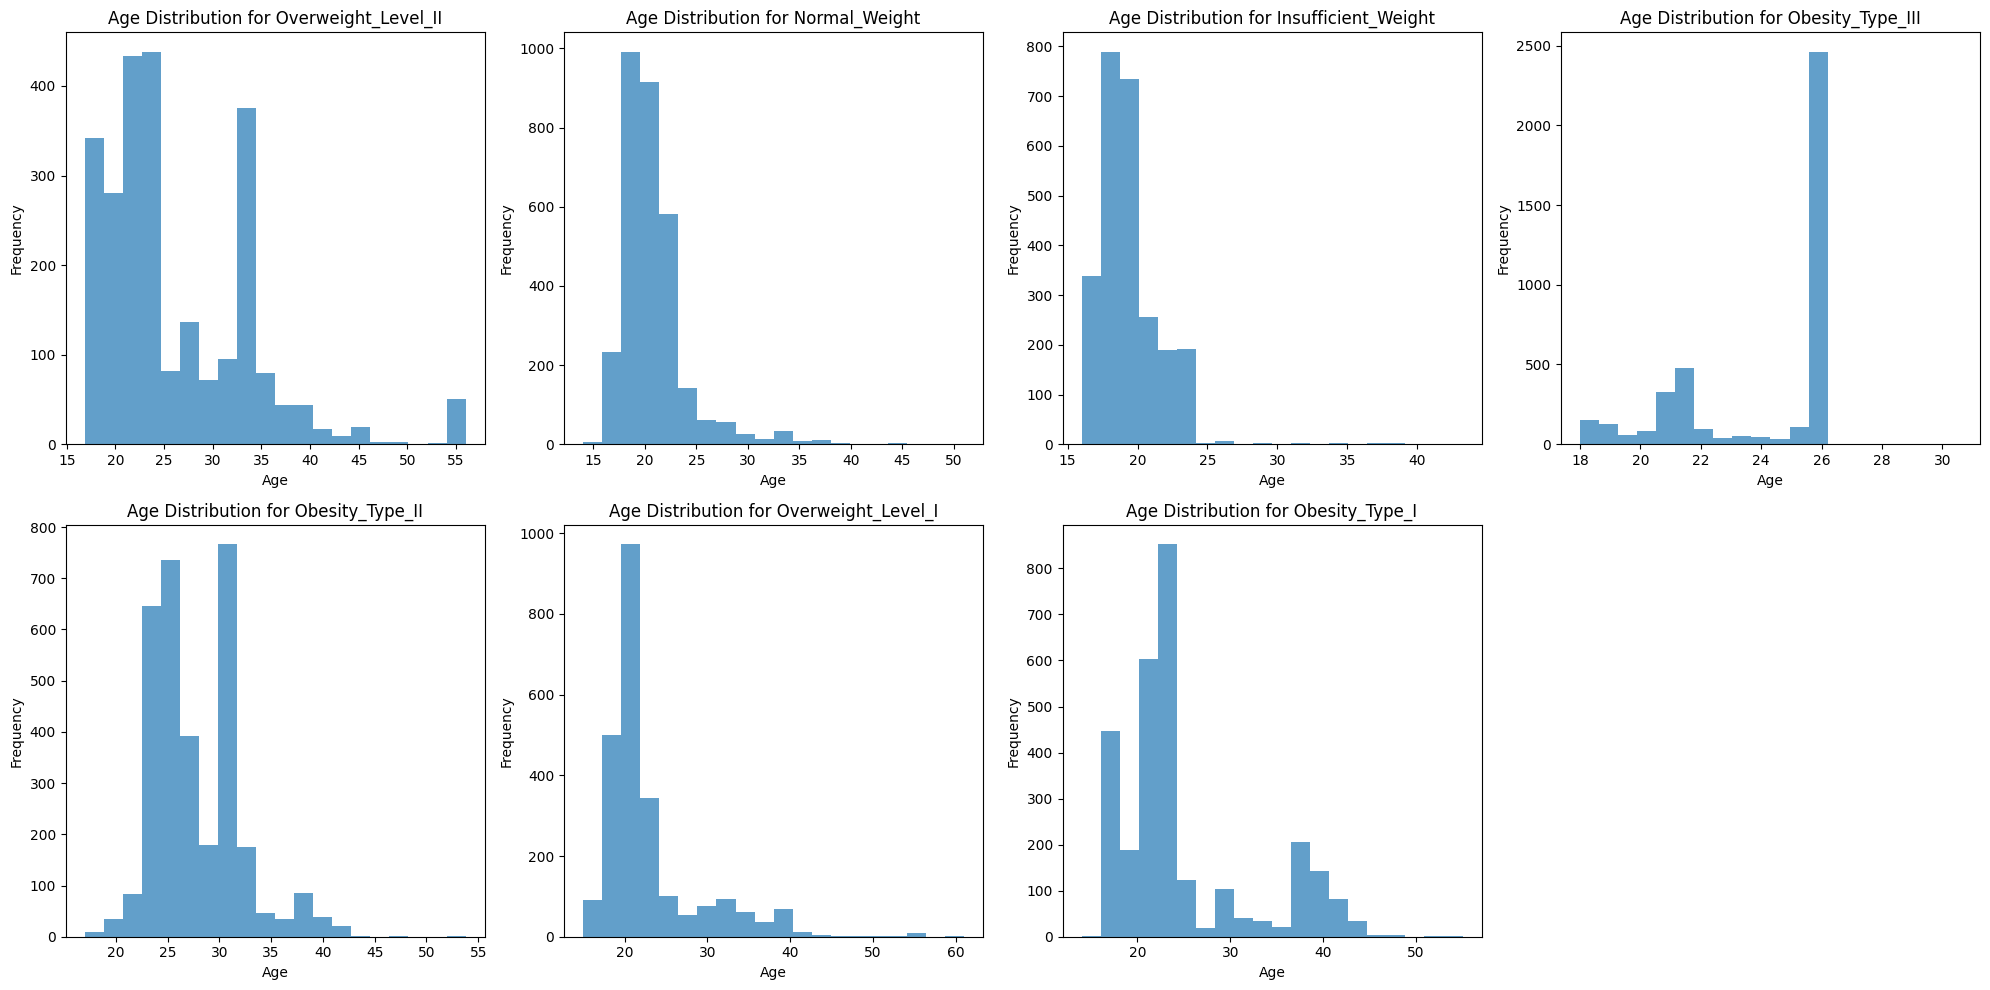

In [4]:
# Visualize the age distribution for each level of obesity in the training data.
unique_categories = df['NObeyesdad'].unique()
print(unique_categories)
plt.figure(figsize=(20,10))

for i, category in enumerate(unique_categories, start=1):
    category_data = df[df['NObeyesdad'] == category]['Age']
    plt.subplot(2, 4, i)
    plt.hist(category_data, bins=20, alpha=0.7)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    

plt.tight_layout()    
plt.show()

In [5]:
# Confirm that there are no missing values in the training data.
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
dtype: int64

In particular we can deduct that:

- 'Gender', 'Age', 'Height', 'Weight' are physical attributes
- 'family_history_with_overweight' points out to familiarity with obesity
- FAVC = Frequent consumption of high caloric food
- FCVC = Frequency of consumption of vegetables
- NCP = Number of main meals
- CAEC = Consumption of food between meals
- SMOKE = tobacco usage
- CH20 = Consumption of water daily
- SCC = Calories consumption monitoring
- FAF = Physical activity frequency
- TUE = Time using technology devices
-CALC = Consumption of alcohol
MTRANS = Transportation used

In [7]:
# Split the training data into X (features, independent variables) and y (labels, dependent variables).
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

# 2.Data exploration and pre-processing

### Numerical DataFrame

In [9]:
# Separate the numerical columns from the independent variables. df_numerical contains the numerical columns before normalization.
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
id,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151
...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,36.587084
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,17.099278
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,31.889841


In [11]:
## Mean and variance of numeric columns before normalization
print('mean of features')
print(df_numerical.mean())
print('\nvariance of features')
print(df_numerical.var())

mean of features
Age       23.841804
Height     1.700245
Weight    87.887768
FCVC       2.445908
NCP        2.761332
CH2O       2.029418
FAF        0.981747
TUE        0.616756
BMI       30.241842
dtype: float64

variance of features
Age        32.354163
Height      0.007623
Weight    695.875017
FCVC        0.284322
NCP         0.497553
CH2O        0.370232
FAF         0.702750
TUE         0.362541
BMI        69.454421
dtype: float64


In [21]:
# Start Scale -> Use StandardScaler
from sklearn.preprocessing import StandardScaler


#Creating objects
scaler = StandardScaler()
scaler.fit(df_numerical)

numerical_scaled = scaler.transform(df_numerical)
df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

print('mean of features')
print(df_numerical_scaled.mean())
print('\nvariance of features')
print(df_numerical_scaled.var())


mean of features
Age       1.889486e-16
Height   -1.107677e-15
Weight   -1.297310e-16
FCVC      1.095354e-16
NCP       1.762836e-17
CH2O     -2.931785e-16
FAF       3.902200e-17
TUE       1.328117e-16
BMI       1.937408e-16
dtype: float64

variance of features
Age       1.000048
Height    1.000048
Weight    1.000048
FCVC      1.000048
NCP       1.000048
CH2O      1.000048
FAF       1.000048
TUE       1.000048
BMI       1.000048
dtype: float64


In [22]:
# Identify outliers -> but Outliers do not remove them because they are meaningful outliers.
import pandas as pd

# Calculate the number of outliers for each numeric columns
outliers = pd.DataFrame(index=df_numerical.columns, columns=["Has Outliers", "Outlier Count"])

for column in df_numerical.columns:
    Q1 = df_numerical[column].quantile(0.25)
    Q3 = df_numerical[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_count = ((df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)).sum()
    
    outliers.loc[column, "Has Outliers"] = outlier_count > 0
    outliers.loc[column, "Outlier Count"] = outlier_count

print(outliers)


       Has Outliers Outlier Count
Age            True          1074
Height         True             4
Weight        False             0
FCVC          False             0
NCP            True          6052
CH2O          False             0
FAF           False             0
TUE           False             0
BMI           False             0


### Categorical DataFrame

In [23]:
# Extract only categorical columns and see the number of elements in each column
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


Gender
Female    10422
Male      10336
Name: count, dtype: int64
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
FAVC
yes    18982
no      1776
Name: count, dtype: int64
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SCC
no     20071
yes      687
Name: count, dtype: int64
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


# 3. Encoding

In [24]:
# Categorical column encoding
df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
df_encoded['MTRANS'] = df_categorical['MTRANS'].map({'Automobile':0, 'Bike':1, 'Motorbike':2, 'Public_Transportation':3, 'Walking':4})

df_encoded

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
id,,,,,,,,
0,0,1,1,1,0,0,1,3
1,1,1,1,2,0,0,0,0
2,1,1,1,1,0,0,0,3
3,1,1,1,1,0,0,1,3
4,0,1,1,1,0,0,1,3
...,...,...,...,...,...,...,...,...
20753,0,1,1,1,0,0,1,3
20754,0,0,1,2,0,0,1,3
20755,0,1,1,1,0,0,0,3


### Concatenate all features together

In [25]:
# df_all_features is an independent variable dataframe in which both scale and encoding are finally completed
df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

df_all_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0,1,1,1,0,0,1,3
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,1,1,1,2,0,0,0,0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,1,1,1,1,0,0,0,3
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,1,1,1,1,0,0,1,3
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,0,1,1,1,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0,1,1,1,0,0,1,3
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,0,0,1,2,0,0,1,3
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,0,1,1,1,0,0,0,3
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,0,1,1,1,0,0,0,0


### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [26]:
# Creating above preprocessing code as pipeline function code -> Will be used to preprocesse independent variables of test data.
def apply_preprocessing(data):
    features = data.copy(deep=True)
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
   
    numerical_scaled = scaler.transform(df_numerical)
    df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['MTRANS'] = df_categorical['MTRANS'].map({'Automobile':0, 'Bike':1, 'Motorbike':2, 'Public_Transportation':3, 'Walking':4})
    
    df_numerical_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)

    df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

    
    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [27]:
# Import test data. The entire test data file becomes an independent variable.
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col = 0)
df_test["BMI"] = df_test["Weight"]/(df_test["Height"]*df_test["Height"])

# Encoding and applying scale using the preprocessed pipeline function 'apply_preprocessing' created above
df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)
print(df_test.head())
assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')
        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.537644  1.695675  1.241770  0.924049  0.338364  1.308584 -0.150721   
1 -0.499620 -1.148152 -0.829748 -0.836279 -2.497077  1.595165  0.021775   
2  0.379434 -0.651587  0.898933  1.039171  0.338364  0.973714 -1.171141   
3 -0.503267 -1.685011  0.598259 -0.836279  0.307045  1.244138 -1.057992   
4  0.379434 -0.834373  0.642469  1.039171  0.338364  1.025738 -1.171141   

        TUE       BMI  Gender  family_history_with_overweight  FAVC  CAEC  \
0 -1.024344  0.608799      

### Labels

In [28]:
# labels are the dependent columns of the train data
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [29]:
# Encoding the value of labels
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()


NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
Name: count, dtype: int64

# 4.Prepare data for machine learning

In [30]:
from sklearn.model_selection import train_test_split


# X is the independent variable of the train data, y is the dependent variable of the train data
X = df_all_features.loc[: , ["BMI", "Height", "Weight", "FCVC", "CH2O", "NCP", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]]
# When training a machine learning model, it is often safe to use np.label() to transform the target variable into a one-dimenstional array.
y = np.ravel(labels_encoded)

# compare train and test data
# X_test is the independent variable of the test data
X_test = df_test.loc[: , ["BMI", "Height", "Weight", "FCVC", "CH2O", "NCP", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC","MTRANS"]]
assert all(X_test.columns == X.columns), "Columns of trainging and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

# Distribute training data to create validation data
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Number of samples 20758
Number of featires 16


## Fit the data with baseline models

In [31]:
# First, measure the accuracy using four models as default values.
# Use Gradient Boost, Random Forest, LightGBM, XGBoost
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2017
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 16
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [32]:
# Function that evaluate accuracy using X_train and X_validation
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)
    
    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
    
    print('=========================================')

In [33]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 0.999
Test score 0.893
Overfitting detected
LightGBM
Train score 0.976
Test score 0.893
Overfitting detected
Gradient Boosting
Train score 0.918
Test score 0.89
XGBoost
Train score 0.983
Test score 0.893
Overfitting detected


# 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier, LightGBM defined in the previous section, using the optimizer framework called Optuna

In [34]:
# Hyperparameter tuning(XGBoost and LightGBM parameters are tuned at once -> takes a long time)
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost 
    if trial.suggest_categorical('model', ['xgboost', 'lightgbm']) == 'xgboost':
        params = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric':'mlogloss'}

        clf = XGBClassifier(**params)
   
    # LightGBM
    else:
        params = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'lambda_l1': reg_alpha,
                  'lambda_l2': reg_lambda,
                  'colsample_bytree': colsample_bytree, 
                  'subsample': subsample,    
                  'min_child_samples': min_child_weight,
                  'class_weight': 'balanced'}

        clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)
    
    # cross-validation
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [35]:
# Uncomment this section if you want to do hyperparameter tuning
# Hyperparameter tuning start code
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-03-04 01:38:10,739] A new study created in memory with name: no-name-eeb4f163-faff-4941-941a-7bc3dfeed825


Training the model with 16 features


[I 2024-03-04 01:39:52,471] Trial 0 finished with value: 0.8972928036004975 and parameters: {'max_depth': 7, 'n_estimators': 1852, 'gamma': 0.04818888721863546, 'reg_alpha': 0.45964923255119416, 'reg_lambda': 0.06348694086266882, 'min_child_weight': 4, 'subsample': 0.09435175712651034, 'colsample_bytree': 0.7223807510743936, 'learning_rate': 0.07827381023085611, 'model': 'xgboost'}. Best is trial 0 with value: 0.8972928036004975.


Training the model with 16 features


[I 2024-03-04 01:40:21,259] Trial 1 finished with value: 0.8966182441355219 and parameters: {'max_depth': 5, 'n_estimators': 850, 'gamma': 0.9023663830658405, 'reg_alpha': 0.947435105977338, 'reg_lambda': 0.17061830907213593, 'min_child_weight': 9, 'subsample': 0.932662952287571, 'colsample_bytree': 0.6015864876837862, 'learning_rate': 0.4211095658043372, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8972928036004975.


Training the model with 16 features


[I 2024-03-04 01:40:49,978] Trial 2 finished with value: 0.8937759849867873 and parameters: {'max_depth': 9, 'n_estimators': 781, 'gamma': 0.6429756375604413, 'reg_alpha': 0.6679247919779393, 'reg_lambda': 0.06540255307683185, 'min_child_weight': 4, 'subsample': 0.6935020717072223, 'colsample_bytree': 0.5080614991723444, 'learning_rate': 0.46729738499864115, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8972928036004975.


Training the model with 16 features


[I 2024-03-04 01:41:15,445] Trial 3 finished with value: 0.894161573528026 and parameters: {'max_depth': 10, 'n_estimators': 521, 'gamma': 0.44561754004966425, 'reg_alpha': 0.3152370079097082, 'reg_lambda': 0.8999326553106587, 'min_child_weight': 9, 'subsample': 0.023487224281374064, 'colsample_bytree': 0.31685961313854905, 'learning_rate': 0.5474100131674312, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8972928036004975.


Training the model with 16 features


[I 2024-03-04 01:43:01,368] Trial 4 finished with value: 0.8978226455170863 and parameters: {'max_depth': 9, 'n_estimators': 1379, 'gamma': 0.677550886456956, 'reg_alpha': 0.49563191705765597, 'reg_lambda': 0.5699544696575031, 'min_child_weight': 5, 'subsample': 0.5185697493391, 'colsample_bytree': 0.7815277401513435, 'learning_rate': 0.033250096399602524, 'model': 'lightgbm'}. Best is trial 4 with value: 0.8978226455170863.


Training the model with 16 features


[I 2024-03-04 01:43:30,234] Trial 5 finished with value: 0.8917525386783787 and parameters: {'max_depth': 8, 'n_estimators': 813, 'gamma': 0.5589471103904711, 'reg_alpha': 0.6149378619978467, 'reg_lambda': 0.6118165151748831, 'min_child_weight': 0, 'subsample': 0.2872390152155554, 'colsample_bytree': 0.033186639514001026, 'learning_rate': 0.705965345454576, 'model': 'xgboost'}. Best is trial 4 with value: 0.8978226455170863.


Training the model with 16 features


[I 2024-03-04 01:44:29,068] Trial 6 finished with value: 0.8787937326428296 and parameters: {'max_depth': 9, 'n_estimators': 1042, 'gamma': 0.3048314557407287, 'reg_alpha': 0.030151181691312368, 'reg_lambda': 0.4204125702294529, 'min_child_weight': 5, 'subsample': 0.25836760299784334, 'colsample_bytree': 0.7430604447169364, 'learning_rate': 0.5667102666936108, 'model': 'xgboost'}. Best is trial 4 with value: 0.8978226455170863.


Training the model with 16 features


[I 2024-03-04 01:46:04,376] Trial 7 finished with value: 0.8931979735133583 and parameters: {'max_depth': 10, 'n_estimators': 1990, 'gamma': 0.06735068820120005, 'reg_alpha': 0.15925330307000163, 'reg_lambda': 0.8196489942687049, 'min_child_weight': 7, 'subsample': 0.5557258927153337, 'colsample_bytree': 0.4672019708972994, 'learning_rate': 0.15805140231454406, 'model': 'lightgbm'}. Best is trial 4 with value: 0.8978226455170863.


Training the model with 16 features


[I 2024-03-04 01:46:32,942] Trial 8 finished with value: 0.897581658480975 and parameters: {'max_depth': 7, 'n_estimators': 1092, 'gamma': 0.902740114975119, 'reg_alpha': 0.020138930018485213, 'reg_lambda': 0.22979391476260203, 'min_child_weight': 7, 'subsample': 0.8124935777952208, 'colsample_bytree': 0.13022846804137334, 'learning_rate': 0.9917467927548121, 'model': 'xgboost'}. Best is trial 4 with value: 0.8978226455170863.


Training the model with 16 features


[I 2024-03-04 01:47:11,828] Trial 9 finished with value: 0.8918973142483948 and parameters: {'max_depth': 8, 'n_estimators': 1003, 'gamma': 0.0206106612441056, 'reg_alpha': 0.19977404726133152, 'reg_lambda': 0.848048585708102, 'min_child_weight': 3, 'subsample': 0.3977185452400148, 'colsample_bytree': 0.6288445209676038, 'learning_rate': 0.4668004022522111, 'model': 'lightgbm'}. Best is trial 4 with value: 0.8978226455170863.


In [36]:
# Hyperparameter result output
# in the order of the highest accuracy
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_model,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
4,4,0.897823,2024-03-04 01:41:15.446917,2024-03-04 01:43:01.367972,0 days 00:01:45.921055,0.781528,0.677551,0.033250,9,5,lightgbm,1379,0.495632,0.569954,0.518570,COMPLETE
8,8,0.897582,2024-03-04 01:46:04.377097,2024-03-04 01:46:32.941392,0 days 00:00:28.564295,0.130228,0.902740,0.991747,7,7,xgboost,1092,0.020139,0.229794,0.812494,COMPLETE
0,0,0.897293,2024-03-04 01:38:10.740499,2024-03-04 01:39:52.471031,0 days 00:01:41.730532,0.722381,0.048189,0.078274,7,4,xgboost,1852,0.459649,0.063487,0.094352,COMPLETE
1,1,0.896618,2024-03-04 01:39:52.475893,2024-03-04 01:40:21.258398,0 days 00:00:28.782505,0.601586,0.902366,0.421110,5,9,lightgbm,850,0.947435,0.170618,0.932663,COMPLETE
3,3,0.894162,2024-03-04 01:40:49.979938,2024-03-04 01:41:15.445244,0 days 00:00:25.465306,0.316860,0.445618,0.547410,10,9,lightgbm,521,0.315237,0.899933,0.023487,COMPLETE
2,2,0.893776,2024-03-04 01:40:21.260066,2024-03-04 01:40:49.978077,0 days 00:00:28.718011,0.508061,0.642976,0.467297,9,4,lightgbm,781,0.667925,0.065403,0.693502,COMPLETE
7,7,0.893198,2024-03-04 01:44:29.069639,2024-03-04 01:46:04.375280,0 days 00:01:35.305641,0.467202,0.067351,0.158051,10,7,lightgbm,1990,0.159253,0.819649,0.555726,COMPLETE
9,9,0.891897,2024-03-04 01:46:32.943148,2024-03-04 01:47:11.827397,0 days 00:00:38.884249,0.628845,0.020611,0.466800,8,3,lightgbm,1003,0.199774,0.848049,0.397719,COMPLETE
5,5,0.891753,2024-03-04 01:43:01.369899,2024-03-04 01:43:30.233605,0 days 00:00:28.863706,0.033187,0.558947,0.705965,8,0,xgboost,813,0.614938,0.611817,0.287239,COMPLETE
6,6,0.878794,2024-03-04 01:43:30.235450,2024-03-04 01:44:29.067984,0 days 00:00:58.832534,0.743060,0.304831,0.566710,9,5,xgboost,1042,0.030151,0.420413,0.258368,COMPLETE


In [37]:
# XGBoost Optimal Hyperparameter Output
print("Best params for XGBoost:")
xgboost_params = df_study[df_study['params_model'] == 'xgboost'].iloc[0]
xgboost_params.pop('number')  # 'number' key remove
xgboost_params.pop('value')  # 'value' key remove
xgboost_params.pop('datetime_start')  # 'datetime_start' key remove
xgboost_params.pop('datetime_complete')  # 'datetime_complete' key remove
xgboost_params.pop('duration')  # 'duration' key remove
xgboost_params.pop('state')  # 'state' key remove
xgboost_params.pop('params_model') # 'params_model' key remove


best_params_XGB = {key.replace('params_',''): value for key, value in xgboost_params.items()}
print(best_params_XGB)

# LightGBM Optimal Hyperparameter Output
print("\nBest params for LightGBM:")
lightgbm_params = df_study[df_study['params_model'] == 'lightgbm'].iloc[0]
lightgbm_params.pop('number')  # 'number' key remove
lightgbm_params.pop('value')  # 'value' key remove
lightgbm_params.pop('datetime_start')  # 'datetime_start' key remove
lightgbm_params.pop('datetime_complete')  # 'datetime_complete' key remove
lightgbm_params.pop('duration')  # 'duration' key remove
lightgbm_params.pop('state')  # 'state' key remove
lightgbm_params.pop('params_model') # 'params_model' key remove

best_params_LGBM = {key.replace('params_', ''):value for key, value in lightgbm_params.items()}
best_params_LGBM

Best params for XGBoost:
{'colsample_bytree': 0.13022846804137334, 'gamma': 0.902740114975119, 'learning_rate': 0.9917467927548121, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 1092, 'reg_alpha': 0.020138930018485213, 'reg_lambda': 0.22979391476260203, 'subsample': 0.8124935777952208}

Best params for LightGBM:


{'colsample_bytree': 0.7815277401513435,
 'gamma': 0.677550886456956,
 'learning_rate': 0.033250096399602524,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 1379,
 'reg_alpha': 0.49563191705765597,
 'reg_lambda': 0.5699544696575031,
 'subsample': 0.5185697493391}

In [27]:
# Collection of models to use as a base model in stacking
base_models = [
    ('xgboost', XGBClassifier(**best_params_XGB)),
    ('lightgbm', LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)),
]

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)
#  2 models above as estimators, using logistic regression as final_estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

stacking_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5025616732829006,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.9446060249871868,
                                              grow_policy=None,
                                              importance_type=None,
                                              intera...
                                              random_state=None, ...)),
                               ('lightgbm',
                                LGBMClassifier(colsample_bytree=0.6887969053502656,
                                               gamma=0.22192354930290237,
                                               learning_rate=0.009281736307668285,
                                               max_depth=6, min_child_weight=4,
                                               n_estimators=1959,
                                               reg_alpha=0.5825318169558447,
                                               reg_lambda=0.4799149236925663,
                                               subsample=0.015476748135703627,
                                               verbose=-1, verbosity=-1))],
                   final_estimator=LogisticRegression())

In [29]:
# Estimate the accuracy of the final stacking model(Using validation data)
from sklearn.metrics import accuracy_score
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(accuracy_val)

0.9072736030828517


In [30]:
# Expect dependent variables in test data as final stacking model
y_pred_test = stacking_model.predict(X_test)
y_pred_test[:10]

array([5, 2, 6, 4, 6, 0, 0, 1, 3, 1])

In [31]:
# Transformation for Submission
# If you want to submit the results using stacking, you can submit this.
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = y_pred_test
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission_stacking(XGB_LGBM).csv')



                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]


## 6. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost or LightGBM together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, X_test):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(X)[train_index, :]
        y_train = np.array(y)[train_index]
        X_val = np.array(X)[val_index, :]
        y_val = np.array(y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        clf = XGBClassifier(**best_params_XGB)
        clf.fit(X=X_train, y=y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=10,
                verbose=50)
        
        # If you want to use LightGBM instead of XGBoost, use the comment code below
        #clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
        #clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
        
        y_pred_val = clf.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test_proba = clf.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(clf)
        
    return scores, np.array(predictions), clfs

In [33]:
scores, predictions, clfs = train_evaluate_model(X, y, X_test)

Fitting with k-fold 1 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.80747	validation_1-mlogloss:1.81160


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.36199	validation_1-mlogloss:0.39500
[100]	validation_0-mlogloss:0.24984	validation_1-mlogloss:0.29067
[150]	validation_0-mlogloss:0.22459	validation_1-mlogloss:0.27216
[200]	validation_0-mlogloss:0.21576	validation_1-mlogloss:0.26836
[250]	validation_0-mlogloss:0.21175	validation_1-mlogloss:0.26711
[300]	validation_0-mlogloss:0.20921	validation_1-mlogloss:0.26645
[345]	validation_0-mlogloss:0.20777	validation_1-mlogloss:0.26610
validation score is 0.9092003853564548
Round 1 Predictions stored successfully
Fitting with k-fold 2 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.80745	validation_1-mlogloss:1.80999


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.35783	validation_1-mlogloss:0.40834
[100]	validation_0-mlogloss:0.24671	validation_1-mlogloss:0.31125
[150]	validation_0-mlogloss:0.22133	validation_1-mlogloss:0.29407
[200]	validation_0-mlogloss:0.21304	validation_1-mlogloss:0.29027
[250]	validation_0-mlogloss:0.20887	validation_1-mlogloss:0.28870
[254]	validation_0-mlogloss:0.20854	validation_1-mlogloss:0.28883
validation score is 0.899325626204239
Round 2 Predictions stored successfully
Fitting with k-fold 3 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.80825	validation_1-mlogloss:1.81029


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.36277	validation_1-mlogloss:0.39201
[100]	validation_0-mlogloss:0.25116	validation_1-mlogloss:0.28996
[150]	validation_0-mlogloss:0.22516	validation_1-mlogloss:0.27004
[200]	validation_0-mlogloss:0.21680	validation_1-mlogloss:0.26551
[250]	validation_0-mlogloss:0.21290	validation_1-mlogloss:0.26379
[300]	validation_0-mlogloss:0.21014	validation_1-mlogloss:0.26273
[309]	validation_0-mlogloss:0.20975	validation_1-mlogloss:0.26279
validation score is 0.9111271676300579
Round 3 Predictions stored successfully
Fitting with k-fold 4 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.80753	validation_1-mlogloss:1.80794


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.36066	validation_1-mlogloss:0.39875
[100]	validation_0-mlogloss:0.24756	validation_1-mlogloss:0.30364
[150]	validation_0-mlogloss:0.22251	validation_1-mlogloss:0.28818
[200]	validation_0-mlogloss:0.21415	validation_1-mlogloss:0.28494
[250]	validation_0-mlogloss:0.21008	validation_1-mlogloss:0.28365
[270]	validation_0-mlogloss:0.20906	validation_1-mlogloss:0.28346
validation score is 0.9036376776680318
Round 4 Predictions stored successfully
Fitting with k-fold 5 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.80517	validation_1-mlogloss:1.80842


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.35974	validation_1-mlogloss:0.40424
[100]	validation_0-mlogloss:0.24888	validation_1-mlogloss:0.30551
[150]	validation_0-mlogloss:0.22420	validation_1-mlogloss:0.28647
[200]	validation_0-mlogloss:0.21699	validation_1-mlogloss:0.28188
[250]	validation_0-mlogloss:0.21312	validation_1-mlogloss:0.28006
[300]	validation_0-mlogloss:0.21052	validation_1-mlogloss:0.27901
[350]	validation_0-mlogloss:0.20832	validation_1-mlogloss:0.27813
[371]	validation_0-mlogloss:0.20789	validation_1-mlogloss:0.27798
validation score is 0.9041194892796917
Round 5 Predictions stored successfully


In [34]:
print('Average evaluation score = ', np.mean(scores))

Average evaluation score =  0.905482069227695


In [35]:
y_test_pred = np.mean(predictions, axis=0)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_pred

array([5, 2, 6, ..., 0, 1, 5])

In [36]:
# If you want to submit the results using cross-validation, you can submit this.
df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

print(df_submission)

df_submission.to_csv('submission_XGB_cross_Val.csv')


                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]


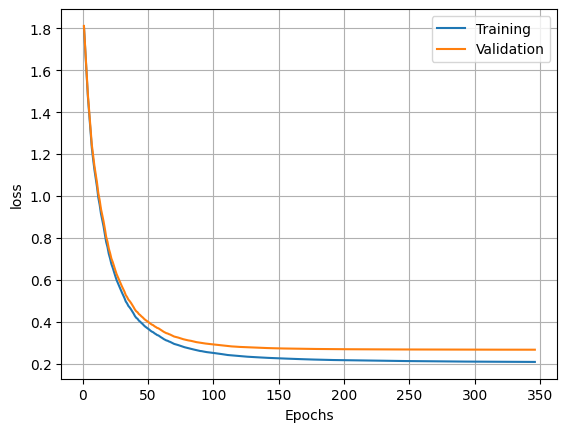

In [37]:
results = clfs[0].evals_result()

train_loss = results['validation_0']['mlogloss']
validation_loss = results['validation_1']['mlogloss']
epochs_grid = np.arange(1, len(train_loss)+1)

plt.plot(epochs_grid, train_loss, label='Training')
plt.plot(epochs_grid, validation_loss, label='Validation')
plt.legend()
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()

## 8. Use this when using voting!/ Use lgbm, xgb, gb as voting algorithm
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [38]:
from sklearn.ensemble import VotingClassifier

clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()
voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(X, y)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.6887969053502656,
                                             gamma=0.22192354930290237,
                                             learning_rate=0.009281736307668285,
                                             max_depth=6, min_child_weight=4,
                                             n_estimators=1959,
                                             reg_alpha=0.5825318169558447,
                                             reg_lambda=0.4799149236925663,
                                             subsample=0.015476748135703627,
                                             verbose=-1, verbosity=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            interaction_constraints=None,
                                            learning_rate=0.07506053282243882,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1117, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [39]:
# If you want to submit the results using voting, you can submit this.
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = voting_clf.predict(X_test)
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)

print(df_submission)

df_submission.to_csv('submission_Voting(lgbm_xgb_gb).csv')

                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]
